# Introduction
This script processes and normalizes stock return data, splitting it into a formation period and a trading period for use in pairs trading strategy. The main goal is to select asset pairs based on past return data and test their performance in a subsequent trading period.

# Workflow Overview
1. Data Preprocessing:
- Ensure the index is in DatetimeIndex format.
- Select data starting from 2018-07-01.
- Normalize returns so that all asset prices start at 1.
2. Formation Period (Training Data):
- overs 2018-07-01 to 2019-06-30, used for selecting trading pairs.
3. Trading Period (Test Data):
- Covers 2019-07-01 to 2019-12-31, used for executing the pairs trading strategy.

# Pairs trading: Pairs selection for Distance Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# read prices from csv file
prices = pd.read_csv('vbr16_19.csv', index_col='Date')

In [3]:
prices

,IEX,NUAN,MOH,NVAX,SBNY,PWR,WSM,FANG,BRO,STLD,...,RES,LE,APEI,FF,WK,PKI,ALGT,SAGE,OII,DRQ
Date,,,,,,,,,,,,,,,,,,,,,
7/1/2016,76.976616,13.567100,49.830002,149.800003,116.435783,22.887882,45.972996,85.069756,17.572161,21.910513,...,14.904593,16.760000,28.219999,5.362969,13.470000,51.718643,138.262650,31.100000,29.461021,59.099998
7/5/2016,75.590309,13.134199,48.240002,144.600006,113.829864,22.759472,44.250740,84.120781,17.387442,21.884090,...,14.506883,16.330000,26.690001,5.353037,13.450000,51.119549,134.303772,31.280001,28.251621,56.540001
7/6/2016,76.311562,13.151515,48.669998,149.199997,115.586044,23.174353,44.882534,85.032166,17.486902,22.482931,...,14.459538,16.100000,27.570000,5.372900,13.400000,51.512394,135.205246,32.320000,28.464476,56.830002
7/7/2016,76.798637,13.376623,48.959999,149.199997,117.115601,23.371920,44.666168,83.237549,17.425331,22.755930,...,14.345906,16.170000,27.799999,5.333174,13.560000,51.649891,135.381775,32.160000,28.396748,56.889999
7/8/2016,78.540871,13.722944,50.209999,152.399994,119.003944,24.063398,46.855759,83.773125,17.685837,23.460453,...,14.648921,16.700001,28.629999,5.556631,13.860000,52.985580,137.705048,33.970001,28.812782,57.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/23/2019,170.038528,18.010000,136.649994,4.000000,131.962463,40.950520,70.886360,84.531479,38.795483,32.447666,...,5.050000,17.809999,27.330000,7.557316,41.470001,96.798271,179.097549,74.639999,15.090000,47.389999
12/24/2019,168.596710,18.000000,136.240005,4.000000,132.428436,40.712379,70.472260,85.623375,38.637653,32.664612,...,5.030000,17.580000,27.430000,7.600537,42.009998,97.037254,179.187058,76.800003,15.140000,47.410000
12/26/2019,169.420593,18.049999,136.380005,4.000000,133.185608,40.920746,71.271553,86.696274,38.834934,32.721199,...,5.110000,18.295000,27.910000,7.705499,41.740002,96.758453,177.973587,74.160004,15.090000,47.840000


In [4]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)

## Functions to calculate different metrics

In [5]:
def calculate_distances(cumret):
    '''
    calculate Euclidean distance for each pair of stocks in the dataframe
    return sorted dictionary (in ascending order)
    '''
    distances = {} # dictionary with distance for each pair
    
    # calculate distances
    for s1 in cumret.columns:
        for s2 in cumret.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in distances.keys()) and (f'{s2}-{s1}' not in distances.keys()):
                dist = np.sqrt(np.sum((cumret[s1] - cumret[s2])**2)) # Euclidean distance
                distances[f'{s1}-{s2}'] = dist
    
    # sort dictionary
    sorted_distances = {k:v for k,v in sorted(distances.items(), key = lambda item: item[1])}
    
    return sorted_distances

def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def calculate_metrics(sorted_distances, cumret, N=5):
    '''
    calculate metrics for N pairs with the smallest Euclidean distance
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        results.loc[pair]['Spread SD'] = spread.std()
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within 2-SD band'] = (abs(spread) < 2*spread.std()).sum() / len(spread) * 100
        
    return results

def plot_pairs(sorted_distances, cumret_train, cumret_test, N=5):
    '''
    plot cumulative returns of the spread for each of N pairs with smallest Euclidean distance
    '''
    pairs = [k for k,v in sorted_distances.items()][:N]
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()


def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'Num zero-crossings', 'Pearson r', 
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = cadf_pvalue(s1,s2,train)
                if cadf_p<0.01:
                    spread = train[s1] - train[s2]
                    hurst = compute_Hc(spread)[0]
                    if hurst<0.5:
                        halflife = calculate_halflife(spread)
                        if halflife>1 and halflife<30:
                            num_crossings = (spread.values[1:] * spread.values[:-1] < 0).sum()
                            if num_crossings>len(train.index)/252*12: 
                                distance = np.sqrt(np.sum((train[s1] - train[s2])**2)) # Euclidean distance
                                pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                spread_sd = spread.std()
                                pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r,
                                                           spread_sd, hurst, halflife]
                                
    return pairs

# 12 months formation period and 6 months trading period

In [6]:
# prepare data
cumret.index = pd.to_datetime(cumret.index)
cumret12_6 = cumret.loc['2018-07-01':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2018-07-01':'2019-06-30'] # formation period
test12_6 = cumret12_6.loc['2019-07-01':'2019-12-31'] # trading period

In [7]:
# calculate Euclidean distances for each pair
sorted_distances12_6 = calculate_distances(train12_6)

In [8]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances12_6.items()][:10]

[['BXMT-PMT', 0.1853466765389923],
 ['ZION-CFR', 0.19955368473824825],
 ['CBSH-CVBF', 0.23162338889797504],
 ['CVBF-NBTB', 0.256394229332227],
 ['CBSH-NBTB', 0.27401925370637015],
 ['CFR-SHO', 0.2796777575582365],
 ['CENTA-CENT', 0.28650499170836546],
 ['UCBI-PRK', 0.29025483079626335],
 ['CUZ-HPP', 0.2933625747927683],
 ['PACW-HOMB', 0.2972769090995326]]

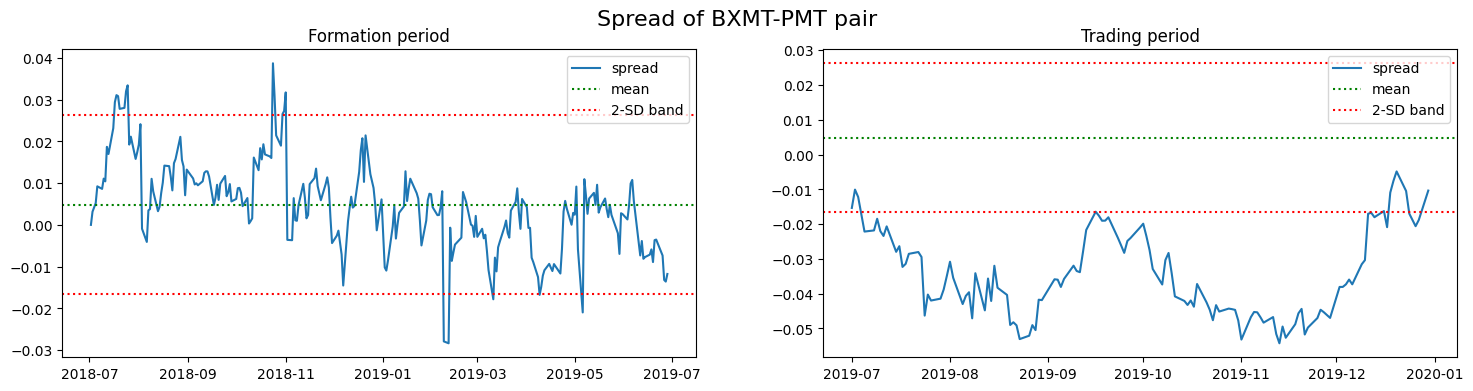

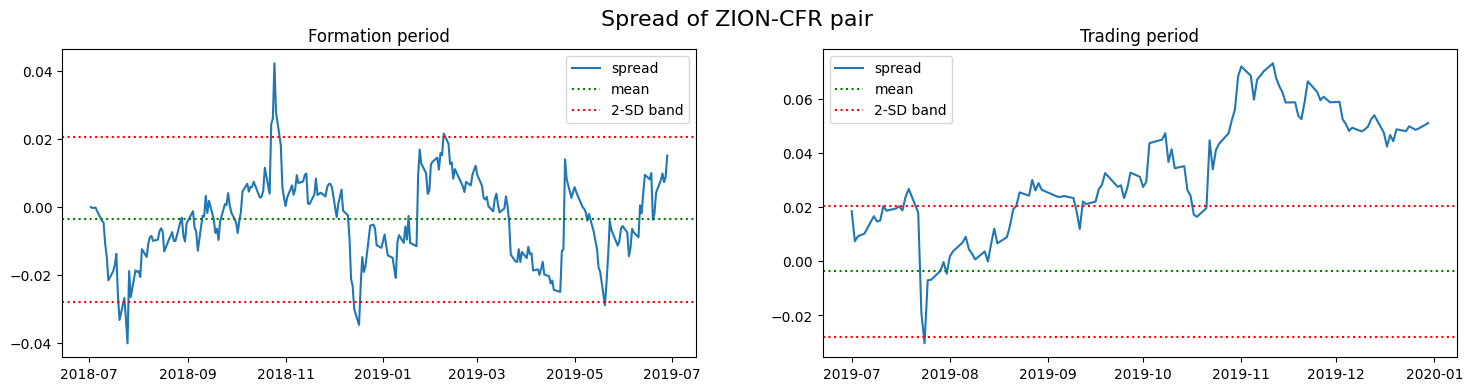

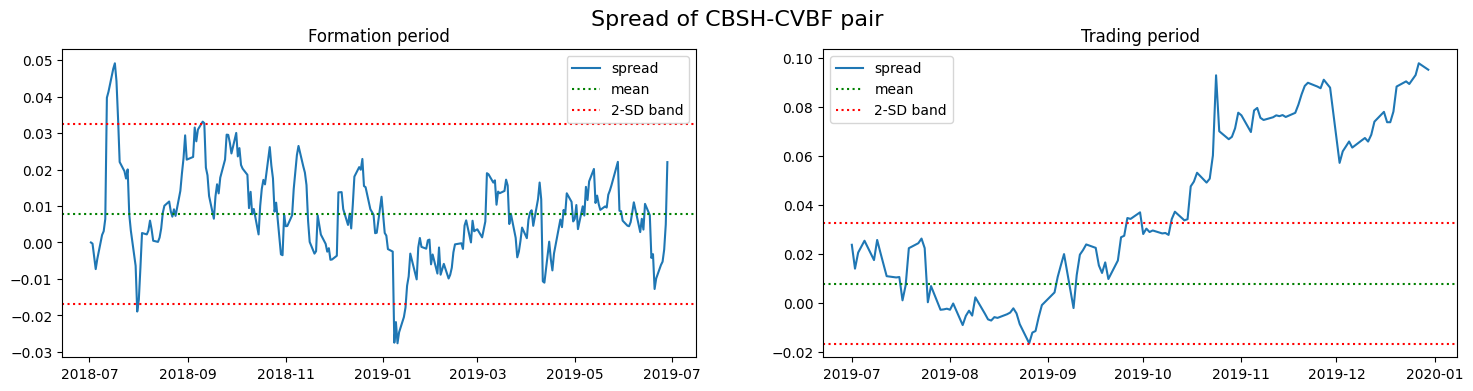

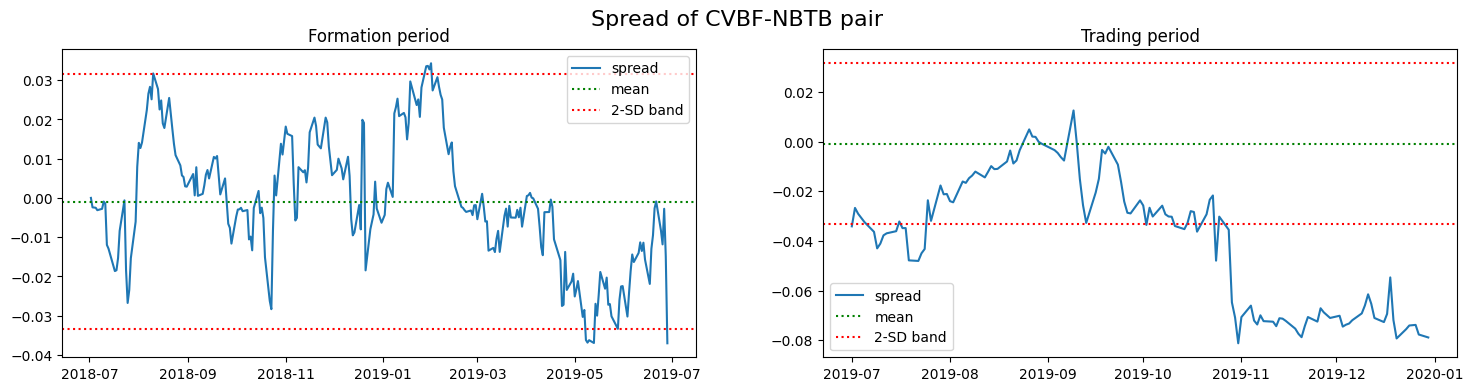

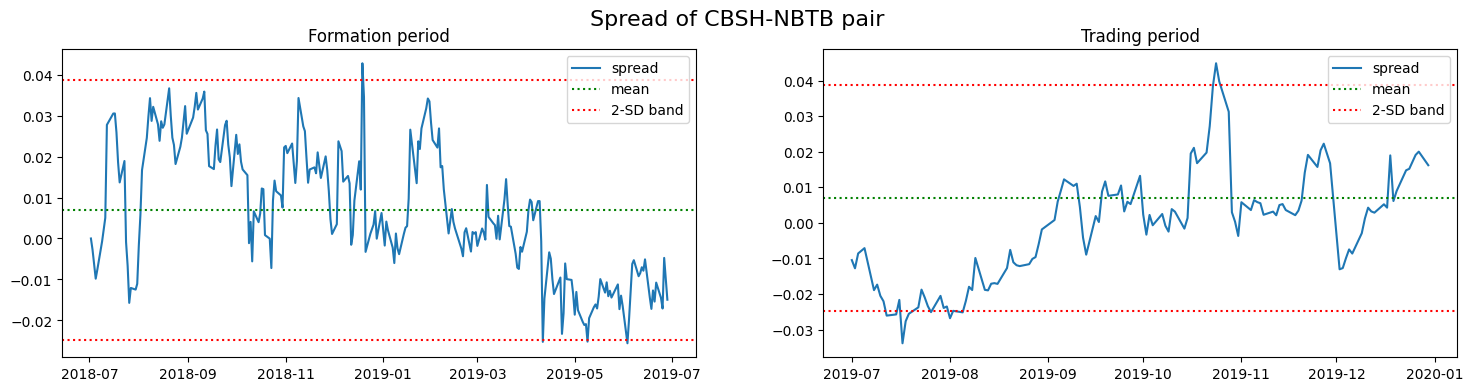

In [9]:
plot_pairs(sorted_distances12_6, train12_6, test12_6)

### Metrics for top5 pairs during 12 months formation period

In [10]:
calculate_metrics(sorted_distances12_6, train12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
BXMT-PMT,0.185347,0.000049,0.014721,0.010702,31,0.317424,3.57473,92.8
ZION-CFR,0.199554,0.033698,0.008456,0.012107,23,0.4535,7.067607,94.0
CBSH-CVBF,0.231623,0.004689,0.001875,0.012397,23,0.385377,5.819853,91.6
CVBF-NBTB,0.256394,0.177118,0.143461,0.016222,18,0.322994,9.735489,96.0
CBSH-NBTB,0.274019,0.046744,0.042703,0.015919,36,0.306952,7.180554,94.8


#### Metrics for top5 pairs during 6 months trading period

In [11]:
calculate_metrics(sorted_distances12_6, test12_6)

,Euclidean distance,CADF p-value,ADF p-value,Spread SD,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within 2-SD band
BXMT-PMT,0.412001,0.342681,0.147309,0.012238,0,0.39562,9.363208,25.984252
ZION-CFR,0.437946,0.227423,0.475875,0.021742,4,0.520924,16.311516,62.204724
CBSH-CVBF,0.569369,0.005272,0.868795,0.033958,6,0.643906,59.468393,71.653543
CVBF-NBTB,0.527637,0.004559,0.713055,0.026426,4,0.600112,26.28249,66.141732
CBSH-NBTB,0.175541,0.201849,0.221612,0.015593,15,0.490445,9.136463,96.062992


## Shortest distance

In [ ]:
pairs12_6 = select_pairs(train12_6)

In [ ]:
pairs12_6.sort_values(by='Euclidean distance')

In [ ]:
top5_distance = list(pairs12_6.sort_values(by='Euclidean distance').index[:5])
plot_pairs(top5_distance, train12_6, test12_6)

In [ ]:
calculate_metrics(top5_distance, test12_6, pairs12_6)

## Highest number of zero crossings

In [ ]:
pairs12_6.sort_values(by='Num zero-crossings', ascending=False)

In [ ]:
top5_crossings = list(pairs12_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train12_6, test12_6)

In [ ]:
calculate_metrics(top5_crossings, test12_6, pairs12_6)

## Highest Pearson r

In [ ]:
pairs12_6.sort_values(by='Pearson r', ascending=False)

In [ ]:
top5_pearson = list(pairs12_6.sort_values(by='Pearson r', ascending=False).index[:5])
plot_pairs(top5_pearson, train12_6, test12_6)

In [ ]:
calculate_metrics(top5_pearson, test12_6, pairs12_6)

# 24 months formation period and 6 months trading period

In [ ]:
# prepare data
cumret.index = pd.to_datetime(cumret.index)
cumret24_6 = cumret.loc['2017-07-01':]
cumret24_6 = cumret24_6 / cumret24_6.iloc[0] # divide by first row so that all prices start at 1
train24_6 = cumret24_6.loc['2017-07-01':'2019-06-30'] # formation period
test24_6 = cumret24_6.loc['2019-07-01':'2019-12-31'] # trading period

In [ ]:
# calculate Euclidean distances for each pair
sorted_distances24_6 = calculate_distances(train24_6)

In [ ]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances24_6.items()][:10]

In [ ]:
plot_pairs(sorted_distances24_6, train24_6, test24_6)

### Metrics for top5 pairs during 24 months formation period

In [ ]:
calculate_metrics(sorted_distances24_6, train24_6)

### Metrics for top5 pairs during 6 months trading period

In [ ]:
calculate_metrics(sorted_distances24_6, test24_6)

## Shortest distance

In [ ]:
pairs24_6 = select_pairs(train24_6)

In [ ]:
pairs24_6.sort_values(by='Euclidean distance')

In [ ]:
top5_distance = list(pairs24_6.sort_values(by='Euclidean distance').index[:5])

In [ ]:
plot_pairs(top5_distance, train24_6, test24_6)

In [ ]:
calculate_metrics(top5_distance, test24_6, pairs24_6)

## Highest number of zero crossings

In [ ]:
pairs24_6.sort_values(by='Num zero-crossings', ascending=False)

In [ ]:
top5_crossings = list(pairs24_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])

In [ ]:
plot_pairs(top5_crossings, train24_6, test24_6)

In [ ]:
calculate_metrics(top5_crossings, test24_6, pairs24_6)

## Highest Pearson r

In [ ]:
pairs24_6.sort_values(by='Pearson r', ascending=False)

In [ ]:
top5_pearson = list(pairs24_6.sort_values(by='Pearson r', ascending=False).index[:5])

In [ ]:
plot_pairs(top5_pearson, train24_6, test24_6)

In [ ]:
calculate_metrics(top5_pearson, test24_6, pairs24_6)

# 36 months formation period and 6 months trading period

In [ ]:
# prepare data
cumret.index = pd.to_datetime(cumret.index)
cumret36_6 = cumret.loc['2016-07-01':]
cumret36_6 = cumret36_6 / cumret36_6.iloc[0] # divide by first row so that all prices start at 1
train36_6 = cumret36_6.loc['2016-07-01':'2019-06-30'] # formation period
test36_6 = cumret36_6.loc['2019-07-01':'2019-12-31'] # trading period

In [ ]:
# calculate Euclidean distances for each pair
sorted_distances36_6 = calculate_distances(train36_6)

In [ ]:
# print top 10 pairs with smallest distance
[[k,v] for k,v in sorted_distances36_6.items()][:10]

In [ ]:
plot_pairs(sorted_distances36_6, train36_6, test36_6)

### Metrics for top5 pairs during 36 months formation period

In [ ]:
calculate_metrics(sorted_distances36_6, train36_6)

### Metrics for top5 pairs during 6 months trading period

In [ ]:
calculate_metrics(sorted_distances36_6, test36_6)

## Shortest distance

In [ ]:
pairs36_6 = select_pairs(train36_6)

In [ ]:
pairs36_6.sort_values(by='Euclidean distance')

In [ ]:
top5_distance = list(pairs36_6.sort_values(by='Euclidean distance').index[:5])

In [ ]:
plot_pairs(top5_distance, train36_6, test36_6)

In [ ]:
calculate_metrics(top5_distance, test36_6, pairs36_6)

## Highest number of zero crossings

In [ ]:
pairs36_6.sort_values(by='Num zero-crossings', ascending=False)

In [ ]:
top5_crossings = list(pairs36_6.sort_values(by='Num zero-crossings', ascending=False).index[:5])

In [ ]:
plot_pairs(top5_crossings, train36_6, test36_6)

In [ ]:
calculate_metrics(top5_crossings, test36_6, pairs36_6)

## Highest Pearson r

In [ ]:
pairs36_6.sort_values(by='Pearson r', ascending=False)

In [ ]:
top5_pearson = list(pairs36_6.sort_values(by='Pearson r', ascending=False).index[:5])

In [ ]:
plot_pairs(top5_pearson, train36_6, test36_6)

In [ ]:
calculate_metrics(top5_pearson, test36_6, pairs36_6)